# Recreate figure 2 from Kay (2012)

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [2]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# In the CAM output, the ISCCP total is named "CLDTOT_ISCCP"

### Find the files

In [3]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

### Load post-processed CAM4 and CAM5 files into a cloud metric

In [4]:
fig2metric = Cloud_Metric(case_dir)
fig2metric.add_case('cam4_1deg_release_amip',label='CAM4')
fig2metric.add_case('cam5_1deg_release_amip',label='CAM5')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.
Processed timeseries directory found for cam5_1deg_release_amip. Will load data as required.
cam5_1deg_release_amip load successfully.


### Variable loading

In [5]:
fig2metric.load_vars('LANDFRAC');
fig2metric.load_vars('CLD_MISR');

### Grab case_das

In [6]:
cam4_da = fig2metric.get_case('cam4_1deg_release_amip').case_da
cam5_da = fig2metric.get_case('cam5_1deg_release_amip').case_da
misr_da = fig2metric.misr_data

### Get land fraction from CAM

In [7]:
landfrac = cam5_da['LANDFRAC'].mean('time')

### (b) MISR observations (τ > 0.3)

#### Process the MISR histograms (slow and awkward)

In [8]:
proc_misr5 = cam5_da['CLD_MISR'].where(cam5_da['CLD_MISR'].cosp_tau > 0.3).sum(['cosp_tau','cosp_htmisr'])
proc_misr5 = proc_misr5.where((landfrac<0.05))

In [9]:
proc_misr4 = cam4_da['CLD_MISR'].where(cam4_da['CLD_MISR'].cosp_tau > 0.3).sum(['cosp_tau','cosp_htmisr'])
proc_misr4 = proc_misr4.where((landfrac<0.05))

In [10]:
proc_misr_obs = misr_da['CLD_MISR'].where(misr_da['CLD_MISR'].cosp_tau > 0.3).sum(['cosp_tau','cosp_htmisr'])
proc_misr_obs = proc_misr_obs.where((landfrac<0.05))

### Testing

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


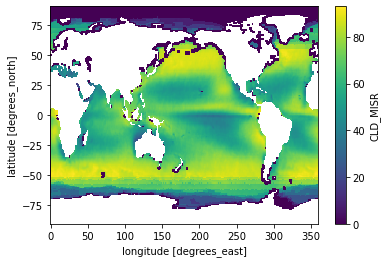

In [11]:
try:
    proc_misr_obs.mean('time').plot()
except:
    proc_misr_obs.plot()

### Assign processed data to a new variable

#### MISR

In [15]:
cam5_da['CLD_MISRp'] = proc_misr5
cam4_da['CLD_MISRp'] = proc_misr4
fig2metric.misr_data['CLD_MISRp'] = proc_misr_obs

## Plot finally!

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_

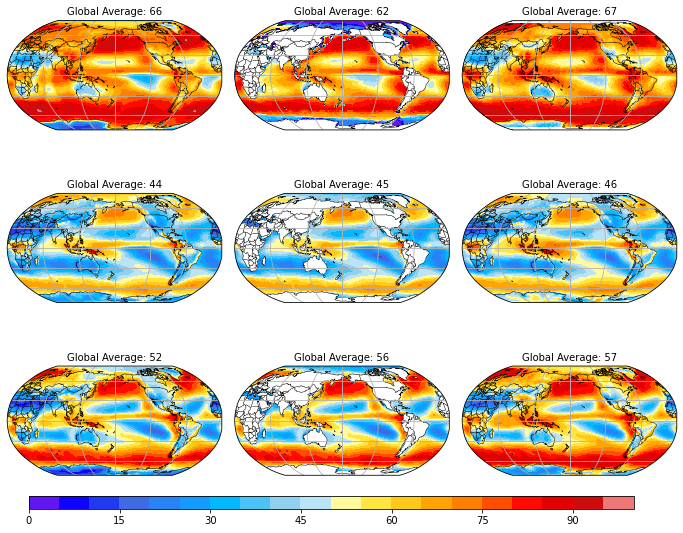

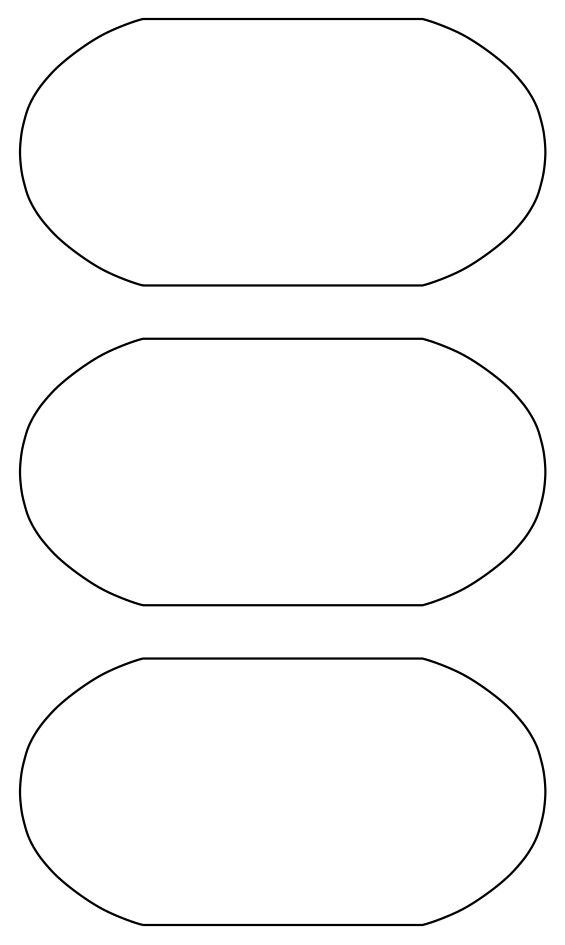

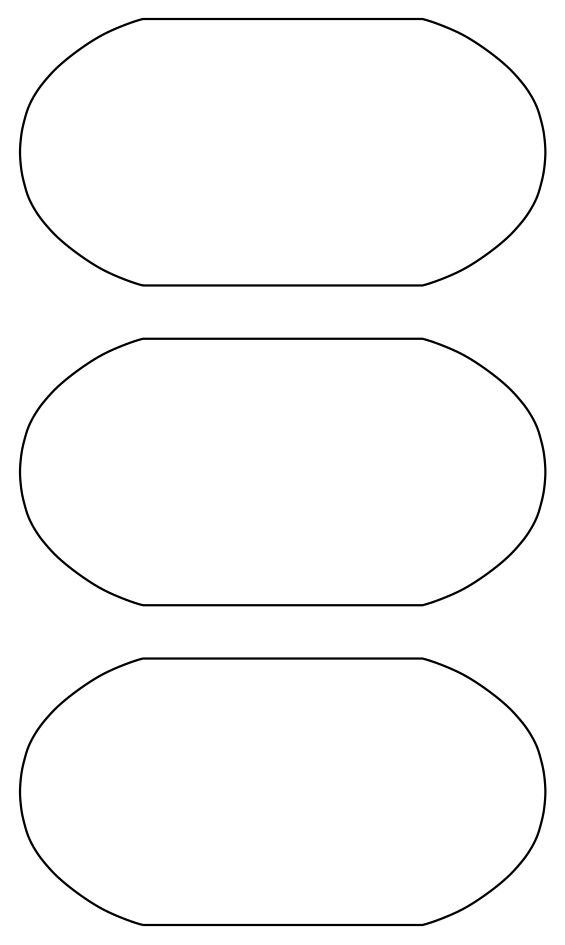

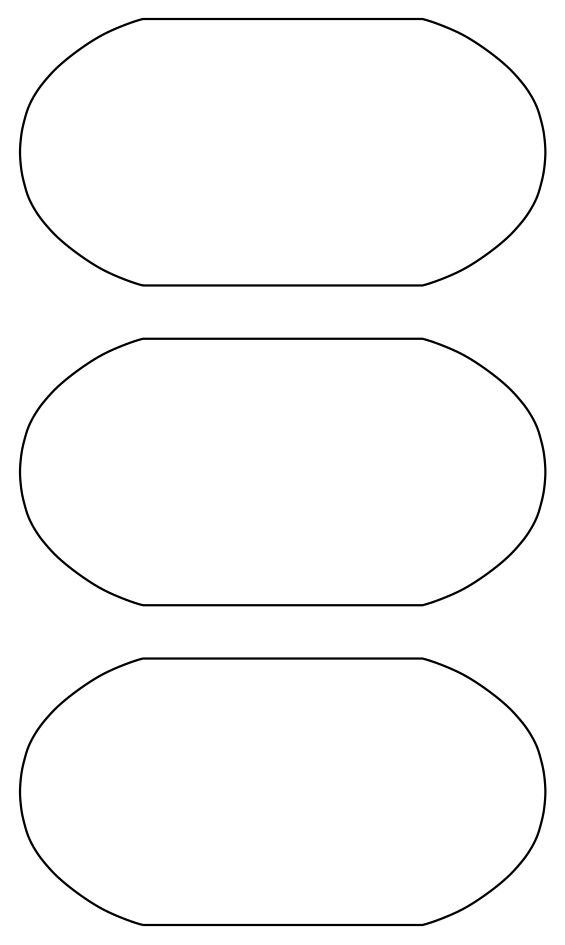

In [20]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=3, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(9)
fig.set_figwidth(12)
# fig.set_dpi(200)
ax1 = axs[:,0]
ax2 = axs[:,1]
ax3 = axs[:,2]

fig.subplots_adjust(wspace=0.06)

cldisccp = fig2metric.plot2D('CLDTOT_ISCCP',projection='Robinson',ax=ax1,
                             contour=True,levels=np.linspace(0,100,21),
                             extend='neither',label=False)

cldmisr = fig2metric.plot2D('CLD_MISRp',projection='Robinson',ax=ax2,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cldcal = fig2metric.plot2D('CLDTOT_CAL',projection='Robinson',ax=ax3,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cbar_axh = fig.add_axes([0.15, 0.10, 0.70, 0.02])

fig.colorbar(cldcal[1], cax=cbar_axh,orientation='horizontal')